In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class one_dimensional_stochastic_process():
    start_time = 50
    end_time = 100
    number_of_steps = 10 
    _position = []
    def __init__(self, start_time = 0, end_time = 1, number_of_steps = 10):
        self.start_time = start_time
        self.end_time = end_time
        self.number_of_steps = number_of_steps
        self._position = [ 0 for step in range(number_of_steps)]
    def build_as_Brownian_motion(self, initial_position = 0, standard_deviation_of_unit_increment = 1):
        self._position = []
        if self.number_of_steps == 0:
            dt = 0
        else:
            dt = (self.end_time - self.start_time) / self.number_of_steps
        increment = [ np.random.normal(scale = standard_deviation_of_unit_increment * dt) for step in range(self.number_of_steps)]
        self._position = np.cumsum([initial_position] + increment).tolist()
    def set_steps_according_to_a_resolution(self, resolution = 0.01):
        self.number_of_steps = int( (self.end_time - self.start_time ) / resolution )
    def draw_on_a_picture(self, picture, color = 'k'):
        if self.number_of_steps > 0:
            dt = (self.end_time - self.start_time) / self.number_of_steps
            xdata_for_the_picture = [self.start_time] + [ (self.start_time + (step+1) * dt)  for step in range(self.number_of_steps)] 
            ydata_for_the_picture = self._position
            picture.plot(xdata_for_the_picture, ydata_for_the_picture,color = color)
    def extinction_position(self):
        return self._position[-1]
    def position_at_a_given_time(self, time = 0):
        if self.number_of_steps == 0:
            position_at_that_time = self._position[0]
        else:
            dt = (self.end_time - self.start_time) / self.number_of_steps
            step_near_that_time = int((time - self.start_time)/ dt)
            previous_recording_time = self.start_time + step_near_that_time * dt
            next_recording_time = previous_recording_time + dt
            previous_position = self._position[step_near_that_time]
            next_position = self._position[step_near_that_time + 1]
            position_at_that_time = self.linear_segment_position(previous_recording_time, time, next_recording_time, previous_position, next_position)
        return position_at_that_time
    def linear_segment_position(self, previous_recording_time, time, next_recording_time, previous_position, next_position):
        precentage_of_the_segment = ((time - previous_recording_time) / (next_recording_time - previous_recording_time))
        segmented_position = (next_position - previous_position) * precentage_of_the_segment + previous_position
        return segmented_position

In [3]:
class random_tree():
# Define Random tree as follows
    parent = [0]
    # There is a list of particles 1,...,n where the parent of the ith particle is particle parentp[i]
    maximum_number_of_particles = 10000
    # In order to avoid bug, we set the maximum number of particles as above
    children = [[]]
    # The children of particle i is listed in children[i]. This children data should be generated from parent.  
    have_children_data = False
    # I want to make sure that the have_children_data is ture iff the children list and the parat list is compatible.
    def __init__(self, maximum_number_of_particles = 100):
        self.parent = [0]
        self.maximum_number_of_particles = maximum_number_of_particles
        self.children = [[]]
        self.have_children_data = False
    def build_as_Galton_Watson_binary_tree(self, mean_of_the_offspring = 1):
        self.parent = [0]
        probability_of_spliting = mean_of_the_offspring / 2
        particle = 0
        number_of_particles = 1
        while particle < number_of_particles:
            if number_of_particles >= (self.maximum_number_of_particles):
                break
            if np.random.uniform() <= probability_of_spliting:
                parent_of_two_new_particles = particle
                self.parent.extend([parent_of_two_new_particles,parent_of_two_new_particles])
                number_of_particles += 2
            particle += 1
        have_children_data = False
    def number_of_particles(self):
        return len(self.parent)
    def list_of_particles(self):
        return range(self.number_of_particles())
    def build_children_data(self):
        self.children = [ [ ] for particle in self.list_of_particles() ]
        for particle in self.list_of_particles():
            self.children[self.parent[particle]].append(particle)
        have_children_data = True
    def children(self, particle):
        if not self.have_children_data:
            self.build_children_data()
            return self.children[particle]
        else:
            return self.children[particle]

In [4]:
class random_continuous_tree(random_tree):
    # Index: particle
    extinction_time = [1]
    start_time = 0
    maximum_extinction_time = 100
    def __init__(self):
        random_tree.__init__(self)
        self.extinction_time = [1]
        self.start_time = 0
        self.maximum_extinction_time = 100
    def build_dummy_extinction_times(self):
        self.extinction_time = [self.start_time for particle in self.list_of_particles()]
    def build_extinction_time_by_exponential_killing(self, expectation_of_life_time = 1):
        self.build_dummy_extinction_times()
        for particle in self.list_of_particles():
            extinction_time_of_this_particle_should_be = self.extinction_time[self.parent[particle]] + np.random.exponential(scale = expectation_of_life_time)
            self.set_extinction_time(particle, extinction_time_of_this_particle_should_be)
    def set_extinction_time(self, particle, extinction_time):
        self.extinction_time[particle] = min(extinction_time, self.maximum_extinction_time)
    def birth_time(self, particle):
        if particle == 0:
            return self.start_time
        else:
            return self.extinction_time[self.parent[particle]]

In [5]:
class branching_stochastic_process(random_continuous_tree):
    # Index: particle
    process = []
    resolution = 0.01
    start_position = 0
    def __init__(self):
        random_continuous_tree.__init__(self)
        self.process = []
        self.resolution = 0.01
        self.start_position = 0
    
    def extinction_position_of_a_particles_parent(self, particle):
        if particle == 0:
            return self.start_position
        else:
            return self.process[self.parent[particle]]._position[-1]
    
    def preparation_before_build_spatial_movement_to_particles(self, scale = 1):
        self.process = [one_dimensional_stochastic_process() for particle in self.list_of_particles()]
        for particle in self.list_of_particles():
            self.process[particle].start_time = self.birth_time(particle)
            self.process[particle].end_time = self.extinction_time[particle]
            self.process[particle].number_of_steps = int( (self.process[particle].end_time - self.process[particle].start_time)/ self.resolution )
            
    def build_as_branching_Brownian_motion(self, mean_of_the_offspring = 1, expectation_of_life_time_of_each_particle = 1):
        self.build_as_Galton_Watson_binary_tree(mean_of_the_offspring = mean_of_the_offspring)
        self.build_extinction_time_by_exponential_killing(expectation_of_life_time = expectation_of_life_time_of_each_particle)
        self.preparation_before_build_spatial_movement_to_particles()
        for particle in self.list_of_particles():
            self.process[particle].build_as_Brownian_motion(initial_position = self.extinction_position_of_a_particles_parent(particle))
    def draw_on_a_picture(self,picture,color = 'k'):
        for particle in self.list_of_particles():
            self.process[particle].draw_on_a_picture(picture,color = color)

In [6]:
class one_dimensional_point_process():
    # Index: particle
    position = [] 
    minimal_position = 0
    maximum_position = 100
    def __init__(self):
        self.position = []
        self.minimal_position = 0
        self.maximum_position = 100
    def build_as_Poission_point_process(self, rate_of_point_process = 1):
        position_of_a_new_particle = self.minimal_position
        while True:
            position_of_a_new_particle += np.random.exponential(scale = (1/rate_of_point_process)) 
            if position_of_a_new_particle > self.maximum_position:
                break
            self.position.append(position_of_a_new_particle)
    def list_of_points(self):
        return range(len(self.position))
 

In [19]:
class binary_branching_stochastic_process_with_a_spine():
    spine = one_dimensional_stochastic_process()
    splitting_point_process = one_dimensional_point_process()
    # Index: point
    splitted_branching_stochastic_process = []
    start_time = 0 
    end_time = 10
    resolution = 0.1
    maximum_number_of_particles_for_each_splitted_branching_process = 1000
    def __init__(self, start_time = 0, end_time = 10, resolution = 0.01):
        self.spine = one_dimensional_stochastic_process()
        self.splitting_point_process = one_dimensional_point_process()
        self.splitted_branching_stochastic_process = []
        self.start_time = start_time
        self.end_time = end_time
        self.resolution = resolution
    def send_simulation_parameter_to_spine_and_splitting_point_process(self):
        self.spine.start_time = self.start_time
        self.spine.end_time = self.end_time
        self.spine.set_steps_according_to_a_resolution(resolution = self.resolution)
        self.splitting_point_process.minimal_position = self.start_time
        self.splitting_point_process.maximum_position = self.end_time
    def build_dummy_splitted_branching_stochastic_process_after_splitting_point_process_is_build(self):
        self.splitted_branching_stochastic_process = [ branching_stochastic_process() for point in self.splitting_point_process.list_of_points() ]
    def send_simulation_parameter_to_splitted_branching_stochastic_process(self):
        for point in self.splitting_point_process.list_of_points():
            self.splitted_branching_stochastic_process[point].maximum_extinction_time = self.end_time
            self.splitted_branching_stochastic_process[point].maximum_number_of_particles = self.maximum_number_of_particles_for_each_splitted_branching_process
            self.splitted_branching_stochastic_process[point].resolution = self.resolution
    def send_splitting_times_to_splitted_branching_stochastic_process_as_start_time(self):
        for point in self.splitting_point_process.list_of_points():
            self.splitted_branching_stochastic_process[point].start_time = self.splitting_point_process.position[point]
    def send_splitting_position_to_splitted_branching_stochastic_process_as_their_start_position(self):
        for point in self.splitting_point_process.list_of_points():
            self.splitted_branching_stochastic_process[point].start_position = self.spine.position_at_a_given_time(time = self.splitting_point_process.position[point])
    def build_as_size_biased_binary_branching_brownian_motion_with_a_spine(self, mean_of_the_offspring = 1, rate_of_the_killing = 1, initial_position = 0):
        self.send_simulation_parameter_to_spine_and_splitting_point_process()
        self.spine.build_as_Brownian_motion(initial_position)
        self.splitting_point_process.build_as_Poission_point_process(rate_of_point_process = rate_of_the_killing * mean_of_the_offspring)
        self.build_dummy_splitted_branching_stochastic_process_after_splitting_point_process_is_build()
        self.send_simulation_parameter_to_splitted_branching_stochastic_process()
        self.send_splitting_times_to_splitted_branching_stochastic_process_as_start_time()
        self.send_splitting_position_to_splitted_branching_stochastic_process_as_their_start_position()
        for point in self.splitting_point_process.list_of_points():
            self.splitted_branching_stochastic_process[point].build_as_branching_Brownian_motion(mean_of_the_offspring = mean_of_the_offspring, expectation_of_life_time_of_each_particle = 1/rate_of_the_killing)
    def draw_on_a_picture_without_spine(self, picture, color = "k"):
        for point in self.splitting_point_process.list_of_points():
            self.splitted_branching_stochastic_process[point].draw_on_a_picture(picture = picture, color = color)
    def draw_on_a_picture_only_spine(self, picture, color = "r"):
        self.spine.draw_on_a_picture(picture = picture, color = color)
    def draw_on_a_picture(self, picture):
        self.draw_on_a_picture_without_spine(picture)
        self.draw_on_a_picture_only_spine(picture)

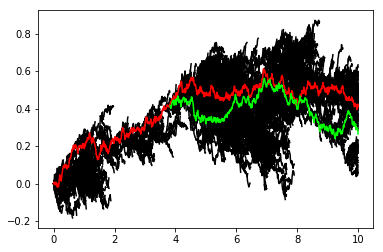

In [24]:
fig, my_picture = plt.subplots()
initial_particle = 25
for i in range(initial_particle):
    superprocess = branching_stochastic_process()
    superprocess.build_as_branching_Brownian_motion(mean_of_the_offspring = 1, expectation_of_life_time_of_each_particle = 1/initial_particle)
    superprocess.draw_on_a_picture(my_picture)
a = binary_branching_stochastic_process_with_a_spine(start_time = 0, end_time = 10)
a.build_as_size_biased_binary_branching_brownian_motion_with_a_spine(mean_of_the_offspring = 1.0, rate_of_the_killing = initial_particle, initial_position = 0)
initial_time_of_the_second_spine = 3.82
initial_position_of_second_spine = a.spine.position_at_a_given_time(initial_time_of_the_second_spine)
b = binary_branching_stochastic_process_with_a_spine(start_time = initial_time_of_the_second_spine, end_time = 10)
b.build_as_size_biased_binary_branching_brownian_motion_with_a_spine(mean_of_the_offspring = 1.0, rate_of_the_killing = initial_particle, initial_position = initial_position_of_second_spine)
a.draw_on_a_picture_without_spine(my_picture)
b.draw_on_a_picture_without_spine(my_picture)
a.draw_on_a_picture_only_spine(my_picture)
b.draw_on_a_picture_only_spine(my_picture, color = '#00FF00')

In [23]:
fig.savefig('plot.eps')